In [2]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

pd.options.display.max_colwidth = 1000

In [3]:
import json
from bs4 import BeautifulSoup
import re


def clean_text(raw_text: str) -> str:
    if raw_text is None:
        return ''

    soup = BeautifulSoup(raw_text, features="html.parser")
    raw_text = soup.get_text()
    raw_text = raw_text.replace('\n', ' ').replace('\xa0', ' ')
    return raw_text


def read_json_as_df(path: str) -> pd.DataFrame:
    json_data = []

    with open(path, 'r', encoding='utf-8') as file:

        for line in file:
            data = json.loads(line)
            json_data.append([clean_text(data['post'].get('body', None)),
                              data['priority']])

    df = pd.DataFrame(data=json_data, columns=('text', 'priority'))

    return df

def read_json_text(path: str, tag: str) -> list:
    json_data = []

    with open(path, 'r', encoding='utf-8') as file:

        for line in file:
            data = json.loads(line)
            json_data.append(clean_text(data.get(tag, None)))

    return json_data

In [4]:
from sklearn.metrics import classification_report, f1_score


def print_results(true_labels, predictions):
    
    print('\n\033[1m-----------Full Classification Report-----------\033[0m\n')
    print(classification_report(true_labels, predictions))
    
    
    print("\n\033[1m------OFFICIAL - ignoring 'green' priority------\033[0m\n")
    print('\tMacro avgd f1 score: ', f1_score(true_labels, predictions, labels=['escalate', 'red', 'amber'], average='macro'))
    
    
    print("\n\033[1m----FLAGGED - 'crisis + red + amber' as flagged vs 'green'----\033[0m\n")
    def map_flagged(label):
        if label in ['escalate', 'red', 'amber']:
            return 'flagged'
        elif label == 'green':
            return 'green'

    flagged_ytest = list(map(map_flagged, true_labels))
    flagged_predictions = list(map(map_flagged, predictions))

    print(classification_report(flagged_ytest, flagged_predictions))
    
    print("\n\033[1m----URGENT - 'red + escalate' as urgent vs 'amber + green' as non_urgent-----\033[0m\n")
    def map_urgent(label):
        if label in ['escalate', 'red']:
            return 'urgent'
        elif label in ['green', 'amber']:
            return 'non-urgent'

    urgent_ytest = list(map(map_urgent, true_labels))
    urgent_predictions = list(map(map_urgent, predictions))

    print(classification_report(urgent_ytest, urgent_predictions))


In [5]:
train_df = read_json_as_df('../Data/combined-train.json')
test_df = read_json_as_df('../Data/combined-test.json')

In [6]:
train_df.text = train_df.text.str.strip()
train_df = train_df[train_df.text != '']

# test_df.text = test_df.text.str.strip()
test_df = test_df[test_df.text != '']

Mean: 426.7756600531167 
Median: 210.0 
Std: 627.1116020203322 


{'whiskers': [<matplotlib.lines.Line2D at 0x206d5df55c0>,
 'caps': [<matplotlib.lines.Line2D at 0x206d5df5cc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x206d5df5470>],
 'medians': [<matplotlib.lines.Line2D at 0x206d5e02400>],
 'fliers': [<matplotlib.lines.Line2D at 0x206d5e02780>],
 'means': []}

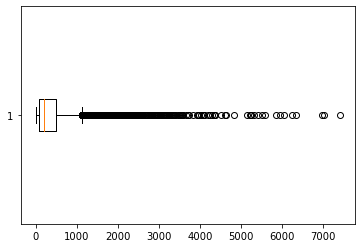

In [7]:
text_lengths = np.array([len(sent) for sent in train_df.text])

print(f'Mean: {np.mean(text_lengths)} \nMedian: {np.median(text_lengths)} \nStd: {np.std(text_lengths)} ')

plt.boxplot(text_lengths, vert=False)

Mean: 541.5175879396985 
Median: 334.5 
Std: 599.5009678846936 


{'whiskers': [<matplotlib.lines.Line2D at 0x206d5e90828>,
 'caps': [<matplotlib.lines.Line2D at 0x206d5e90ef0>,
 'boxes': [<matplotlib.lines.Line2D at 0x206d5e906d8>],
 'medians': [<matplotlib.lines.Line2D at 0x206d5e9b630>],
 'fliers': [<matplotlib.lines.Line2D at 0x206d5e9b9b0>],
 'means': []}

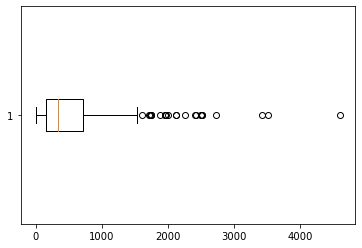

In [8]:
text_lengths = np.array([len(sent) for sent in test_df.text])

print(f'Mean: {np.mean(text_lengths)} \nMedian: {np.median(text_lengths)} \nStd: {np.std(text_lengths)} ')

plt.boxplot(text_lengths, vert=False)

In [9]:
print(train_df.shape)
print(test_df.shape)

(6401, 2)
(398, 2)


In [10]:
train_df.priority.value_counts()

green       3935
amber       1564
red          645
escalate     257
Name: priority, dtype: int64

In [11]:
test_df.priority.value_counts()

green       158
amber       154
red          69
escalate     17
Name: priority, dtype: int64

In [12]:
vectorizer = TfidfVectorizer(ngram_range=(1,1))

# Initial model creation without using test set

In [13]:
features = vectorizer.fit_transform(train_df.text)
test_features = vectorizer.transform(test_df.text)

In [14]:
features.shape

(6401, 16014)

In [15]:
test_features.shape

(398, 16014)

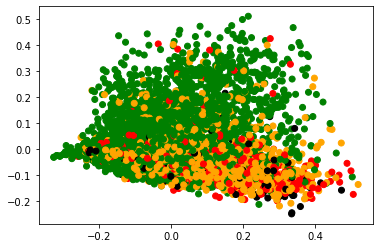

In [16]:
dense_features = features.todense()

pca = PCA(n_components=2).fit(dense_features)

features_2d = pca.transform(dense_features)

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=train_df.priority.map({'green': 'green', 
                                                                           'amber': 'orange',
                                                                           'red': 'red',
                                                                           'escalate': 'black'}))

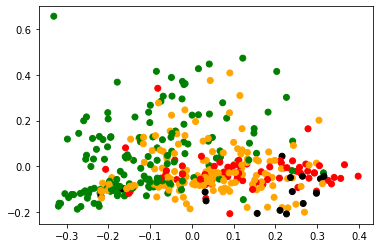

In [19]:
dense_test_features = test_features.todense()

pca = PCA(n_components=2).fit(dense_test_features)

features_2d = pca.transform(dense_test_features)

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=test_df.priority.map({'green': 'green', 
                                                                           'amber': 'orange',
                                                                           'red': 'red',
                                                                           'escalate': 'black'}))

# SVC 

In [20]:
%%time

params = {'C': scipy.stats.expon(scale=10), 'gamma': scipy.stats.expon(scale=.1), 'kernel': ['rbf'], 'class_weight':['balanced']}

clf = RandomizedSearchCV(estimator=SVC(),
                         param_distributions=params,
                         n_jobs=10,
                         scoring='f1_macro',
                         cv=5,
                         n_iter=10)

searched_clf = clf.fit(features, train_df.priority)

print('Best Params:', searched_clf.best_params_, '\n')
print('Best macro avg F1 score:', searched_clf.best_score_, '\n')
print(searched_clf.best_estimator_, '\n')



Best Params: {'C': 5.8816986722954425, 'class_weight': 'balanced', 'gamma': 0.06343402467377951, 'kernel': 'rbf'} 

Best macro avg F1 score: 0.4729565461298483 

SVC(C=5.8816986722954425, class_weight='balanced', gamma=0.06343402467377951) 

Wall time: 2min 24s


In [21]:
predicted_priority = searched_clf.predict(test_features)    
print_results(test_df.priority, predicted_priority)


-----------Full Classification Report-----------

              precision    recall  f1-score   support

       amber       0.65      0.57      0.61       154
    escalate       0.45      0.59      0.51        17
       green       0.72      0.87      0.79       158
         red       0.57      0.41      0.47        69

    accuracy                           0.66       398
   macro avg       0.60      0.61      0.60       398
weighted avg       0.66      0.66      0.65       398


------OFFICIAL - ignoring 'green' priority------

	Macro avgd f1 score:  0.5314311119103637

----FLAGGED - 'crisis + red + amber' as flagged vs 'green'----

              precision    recall  f1-score   support

     flagged       0.90      0.78      0.84       240
       green       0.72      0.87      0.79       158

    accuracy                           0.82       398
   macro avg       0.81      0.83      0.81       398
weighted avg       0.83      0.82      0.82       398


----URGENT - 'red + escalate